<a href="https://colab.research.google.com/github/AbdElRahmanFarhan/box_semantic_segmentation/blob/main/evaluate_maskrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycocotools
!pip install coco-eval

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.6 MB/s eta 0:00:00
  Created wheel for coco-eval: filename=coco_eval-0.0.4-py3-none-any.whl size=5016 sha256=bc3e0577cd6451f75b7cf9b3cfd9557eab7ed66fb92921976aeb645efc82ba36
  Stor

In [2]:
import os
import wandb
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_file_path = '/content/drive/MyDrive/OSCD.zip'
dataset_folder = '/content/drive/MyDrive/OSCD/'

if len(os.listdir(dataset_folder)) == 0:
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(dataset_folder)

  print(f"Unzipped to: {dataset_folder}")

In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_folder = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/images/train2017')
val_folder = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/images/val2017')
train_annotation = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/annotations/instances_train2017.json')
val_annotation = os.path.join(dataset_folder, 'coco_carton/oneclass_carton/annotations/instances_val2017.json')
torch.cuda.empty_cache()

In [5]:
import torch
from torchvision.datasets import CocoDetection
import torchvision.transforms as T
from PIL import Image
from torchvision.tv_tensors import Mask
from torchvision.transforms.functional import to_tensor
from skimage.draw import polygon as sk_polygon


class OSCDDataset(CocoDetection):
    def __init__(self, img_folder, ann_file):
        super().__init__(img_folder, ann_file, transforms=None)

    def __len__(self) -> int:
       return super().__len__()

    def __getitem__(self, idx):
        img, anns = super().__getitem__(idx)

        if anns:
          labels = []
          areas = []
          iscrowd = []
          masks = []
          boxes = []
          ids = []
          for ann in anns:
              x, y, w, h = list(map(int, ann['bbox']))
              boxes.append([x, y, x + w, y + h])
              labels.append(ann['category_id'])
              areas.append(ann['area'])
              iscrowd.append(ann['iscrowd'])
              mask = self.get_mask(ann['segmentation'], img.size[1], img.size[0])
              masks.append(mask)
              ids.append(ann['id'])

          labels = torch.tensor(labels, dtype=torch.int64)
          areas = torch.tensor(areas, dtype=torch.float32)
          iscrowd = torch.tensor(iscrowd, dtype=torch.uint8)
          boxes = torch.tensor(boxes, dtype=torch.int64)
          masks = torch.stack(masks, dim=0)
          ids = torch.tensor(ids, dtype=torch.int64)
          img_id = torch.tensor(ann['image_id'], dtype=torch.int64)

          target = {
              "boxes": boxes,
              "labels": labels,
              "image_id": img_id,
              "ids": ids,
              "area": areas, # TODO: is it area or areas
              "iscrowd": iscrowd,
              "masks": Mask(masks),
          }
        else:
          target = {}
        img = to_tensor(img)
        return img, target

    def get_mask(self, segmentation, height, width):
        mask = torch.zeros((height, width), dtype=torch.bool)
        poly_x = segmentation[0][::2]
        poly_y = segmentation[0][1::2]
        rr, cc = sk_polygon(poly_y, poly_x, shape=(height, width))
        mask[rr, cc] = 1
        return mask


In [12]:
train_dataset = OSCDDataset(train_folder, train_annotation)
val_dataset = OSCDDataset(val_folder, val_annotation)

loading annotations into memory...
Done (t=2.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


In [13]:
def collate_fn(batch):
    images, targets = [], []
    for (image, target) in batch:
      if not target:
        continue
      else:
        images.append(image)
        targets.append(target)
    return images, targets

In [15]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, pin_memory=True)

In [16]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, 2)

model_path = os.path.join(dataset_folder, 'model/model_2025-04-30_22-48-58_qmr3n66t.pth')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=device))
model.to(device)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [23]:
images, targets = next(iter(val_loader))
images = [image.to(device) for image in images]
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
preds = model(images)

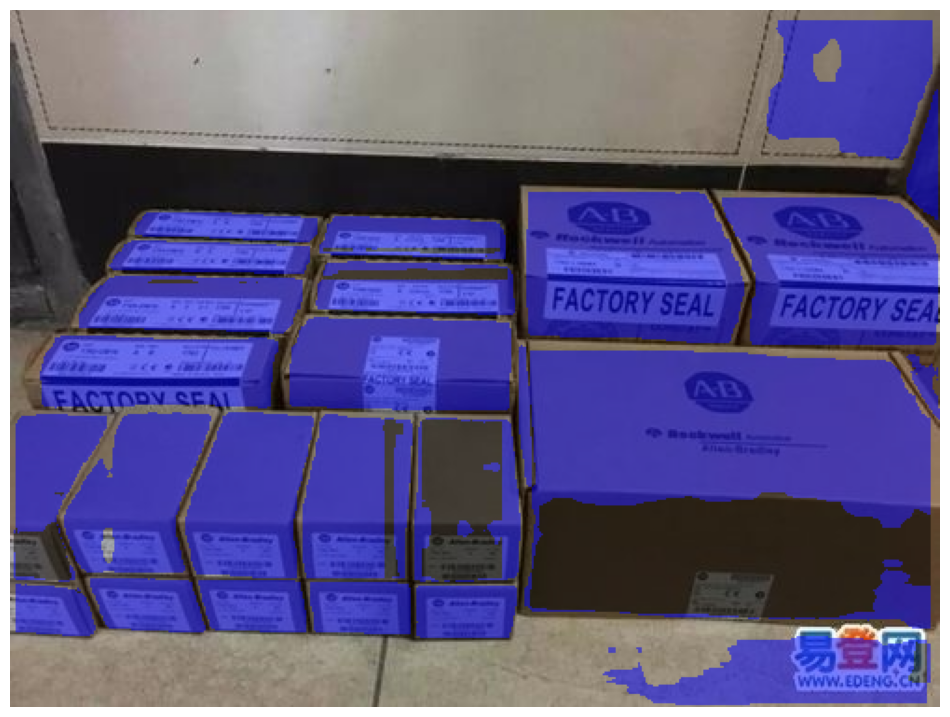

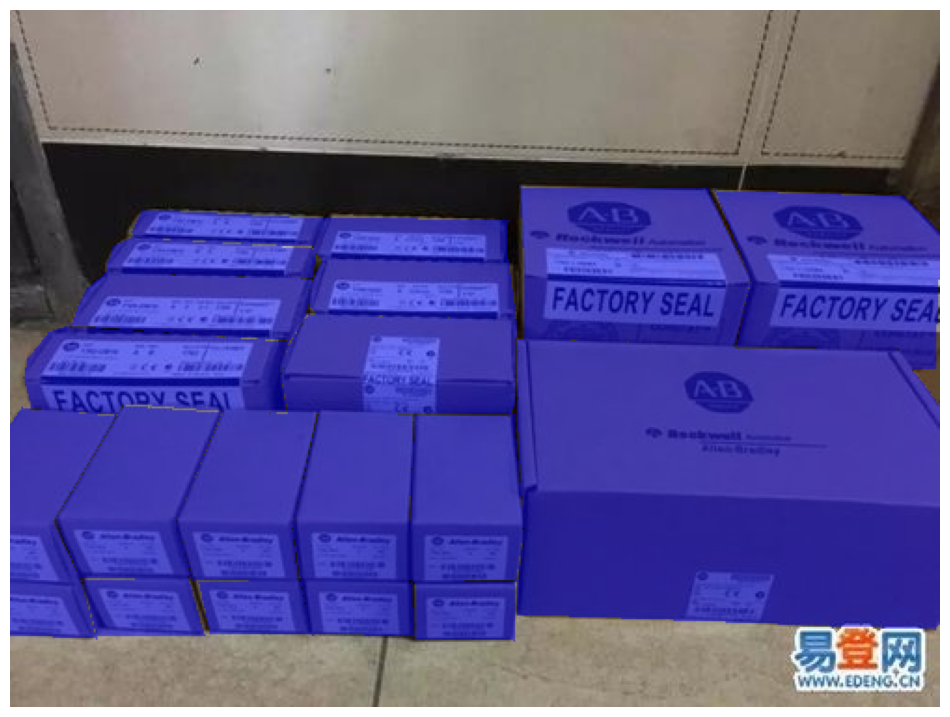

In [24]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


img = images[0]
pred = preds[0]
pred_boxes = pred["boxes"]
pred_labels = pred["labels"]

# plt_img = draw_bounding_boxes(img, pred_boxes, colors="red")
masks = (pred["masks"] > 0.9).squeeze(1)
plt_img = draw_segmentation_masks(img, masks, alpha=0.5, colors="blue")
plt.figure(figsize=(12, 12))
plt.imshow(plt_img.cpu().permute(1, 2, 0))
plt.axis('off')
plt.show()

target = targets[0]
target_boxes = pred["boxes"]
target_labels = pred["labels"]
# plt_img = draw_bounding_boxes(img, target_boxes, colors="red")
masks = (target["masks"] > 0.9).squeeze(1)
plt_img = draw_segmentation_masks(img, masks, alpha=0.5, colors="blue")
plt.figure(figsize=(12, 12))
plt.imshow(plt_img.cpu().permute(1, 2, 0))
plt.axis('off')
plt.show()

In [25]:
from coco_eval import CocoEvaluator
import numpy as np
import pycocotools.mask as mask_util

def prepare_for_coco_segmentation(predictions, targets):
    coco_results = []
    for prediction, target in zip(predictions, targets):
        masks = prediction["masks"]
        masks = masks > 0.5
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()
        rles = [
            mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0] for mask in masks
        ]
        for rle in rles:
            rle["counts"] = rle["counts"].decode("utf-8")
        coco_results.extend(
            [
                {
                    "image_id": target["image_id"].item(),
                    "category_id": labels[k],
                    "segmentation": rle,
                    "score": scores[k],
                }
                for k, rle in enumerate(rles)
            ]
        )
    return coco_results

def evaluate(model, data_loader, device):
    model.eval()
    epoch_loss = torch.zeros(1).to(device)
    coco_eval = CocoEvaluator(data_loader.dataset.coco, ['segm'])
    for i, (images, targets) in enumerate(data_loader):
      images = [image.to(device) for image in images]
      with torch.no_grad():
        predictions = model(images)
        predictions = [{k: v.to('cpu') for k, v in o.items()} for o in predictions]
        coco_results = prepare_for_coco_segmentation(predictions, targets)
        coco_eval.update(coco_results)
        break # TODO: Remove it
    coco_eval.synchronize_between_processes()
    coco_eval.accumulate()
    return coco_eval

In [26]:
eval = evaluate(model, val_loader, device)
eval.summarize()

Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: segm
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.967
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.900
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.975
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.091
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.891
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.973
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.900
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 